In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from matplotlib import animation
from IPython.display import HTML
import matplotlib
import random

# Preprocess data

For convenience, merge data files for all subjects into one file

In [2]:
def merge_txt_files(data_path='data'):
    dfs = []
    for file in os.listdir(data_path):
        file_path = os.path.join(data_path, file)
        if file_path.endswith('.txt'):
            print(file_path)
            dfs.append(pd.read_csv(file_path, sep='\t'))
    df_concat = pd.concat(dfs)
    df_concat.to_csv(os.path.join('raw_data_merged.txt'), index=False, sep='\t')

merge_txt_files()

data\129_1_2019_10_01_10_17_fixed.txt
data\129_1_2019_10_01_10_32.txt
data\129_2_2019_10_01_14_06.txt
data\129_2_2019_10_01_14_18.txt
data\389_1_2019_10_02_10_22.txt
data\389_2_2019_10_03_10_19.txt
data\525_1_2019_10_03_09_21.txt
data\525_2_2019_10_03_14_04.txt
data\616_1_2019_10_03_15_10.txt
data\616_2_2019_10_04_11_03.txt
data\618_1_2019_10_01_09_13.txt
data\618_2_2019_10_02_09_06.txt
data\642_1_2019_10_01_17_28.txt
data\642_2_2019_10_02_17_21_fixed.txt
data\642_2_2019_10_02_17_32.txt
data\755_1_2019_10_04_09_25.txt
data\755_2_2019_10_04_15_06.txt


Response time (RT) is defined as the time between the momen the bot appeared in front of the subject (`idx_bot_spawn`) and the moment the subject pressed the acceleration pedal (`idx_throttle`)

In [2]:
def get_measures(traj):
    '''
    This function extracts dependent variables and some other useful things from an individual trajectory.    
    The time of bot spawn is the first time bot_a is less than 10% of its max value (after the ego car slows
    down to 1 m/s). 
    '''   
    if sum(traj.ego_v<1.0):
        idx_slowdown = (traj.ego_v<1.0).to_numpy().nonzero()[0][0]
        bot_a_max = traj.bot_a.max()  
        idx_bot_spawn = traj.bot_x.to_numpy().nonzero()[0][0] + (traj[idx_slowdown:].bot_a<1).to_numpy().nonzero()[0][0]
        throttle = traj.iloc[idx_bot_spawn:, traj.columns.get_loc('throttle')]
        idx_response = idx_bot_spawn + (throttle>0).to_numpy().nonzero()[0][0]
        RT = traj.t.values[idx_response] - traj.t.values[idx_bot_spawn]
        idx_min_distance = idx_bot_spawn + np.argmin(traj.d_ego_bot[idx_bot_spawn:].values)
        min_distance = min(traj.d_ego_bot[idx_bot_spawn:].values)
    else:
        # if the driver never decelerated to <1m/s, the bot did not spawn
        idx_bot_spawn = -1
        idx_response = -1
        idx_min_distance = -1
        min_distance = -1
        RT = -1
    return pd.Series({'idx_bot_spawn': idx_bot_spawn,
                      'idx_response': idx_response,
                      'idx_min_distance': idx_min_distance,
                      'min_distance': min_distance,
                      'RT': RT})

def get_data(data_file='raw_data_merged.txt'):
    data = pd.read_csv(data_file, sep='\t', index_col=['subj_id', 'session', 'route', 'intersection_no'])
    
    data.loc[:,'t'] = data.t.groupby(data.index.names).transform(lambda t: (t-t.min()))
    
    # we are only intersted in left turns
    data = data[data.turn_direction==1]

    # only consider the data recorded within 10 meters of each intersection
    data = data[abs(data.ego_distance_to_intersection)<10]

    # smooth the time series by filtering out the noise using Savitzky-Golay filter
    apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
    cols_to_smooth = ['ego_x', 'ego_y', 'ego_vx', 'ego_vy', 'ego_ax', 'ego_ay', 
                      'bot_x', 'bot_y', 'bot_vx', 'bot_vy', 'bot_ax', 'bot_ay']
    data.loc[:, cols_to_smooth] = (data.loc[:, cols_to_smooth].groupby(data.index.names).transform(apply_filter))

    # calculate absolute values of speed and acceleration
    data['ego_v'] = np.sqrt(data.ego_vx**2 + data.ego_vy**2)
    data['bot_v'] = np.sqrt(data.bot_vx**2 + data.bot_vy**2)    
    data['ego_a'] = np.sqrt(data.ego_ax**2 + data.ego_ay**2)
    data['bot_a'] = np.sqrt(data.bot_ax**2 + data.bot_ay**2)
    
    # calculate actual distance between the ego vehicle and the bot, and current tta for each t
    data['d_ego_bot'] = np.sqrt((data.ego_x - data.bot_x)**2 + (data.ego_y - data.bot_y)**2)    
    data['tta'] = data.d_ego_bot/data.bot_v
    
    # get the DVs and helper variables
    measures = data.groupby(data.index.names).apply(get_measures)
    
    data = data.join(measures)    
    
    # RT is -1 if a driver didn't stop and the bot did not appear at the intersection; we discard these trials
    data = data[data.RT>0]
    measures = measures[measures.RT>0]    
    
    # add the condition information to the measures dataframe for further analysis
    conditions = data.loc[:,['tta_condition', 'd_condition', 'v_condition']].groupby(data.index.names).first()
    measures = measures.join(conditions)
    
    return data, measures

In [3]:
data, measures = get_data()

# is_turn_decision is calculated based on the minimum distance ever observed between ego and bot during the interaction.
# If the cars were no closer to each other than the lane width (3.5m + 1.5 margin), we count this as a turn decision.
# Based on visual inspection of animations for all trials, this works in all but one trials.
measures['is_turn_decision'] = measures.min_distance > 5

# In some trials this criterion wouldn't work, because e.g. a subject might hit a post after turning left, 
# so that the bot is less than 5m away from the ego car after the turn. We need to check this and fix manually
# measures.loc[(305, 1, 1, 8), ['is_turn_decision']] = True

# add column 'decision' for nicer visualization
measures['decision'] = 'Wait'
measures.loc[measures.is_turn_decision, ['decision']] = 'Turn'
measures_turn = measures[measures.is_turn_decision]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
measures.describe()

,idx_bot_spawn,idx_response,idx_min_distance,min_distance,RT,tta_condition,d_condition,v_condition
count,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000
mean,61.143033,225.249075,466.828607,14.970630,1.710304,4.996301,120.850801,24.844636
std,25.403932,151.677223,216.434483,16.258920,1.519762,0.817244,24.457394,6.503363
min,0.000000,9.000000,10.000000,1.919503,0.071900,4.000000,90.000000,15.000000
25%,45.000000,108.500000,416.000000,3.519540,0.549600,4.000000,90.000000,20.000000
50%,60.000000,148.000000,446.000000,3.940586,0.842400,5.000000,120.000000,24.000000
75%,76.500000,360.000000,531.000000,27.089306,3.146600,6.000000,150.000000,30.000000
max,168.000000,673.000000,5692.000000,102.909617,5.851700,6.000000,150.000000,37.500000


# Visualize decision dynamics

Let's take a look at the time course of an example "trial"

In [18]:
measures

idx_bot_spawn  idx_response  \
subj_id session route intersection_no                                
129     1       1     5                        114.0         161.0   
                      6                         41.0          56.0   
                      8                         45.0          87.0   
                      10                        77.0         124.0   
                      11                        84.0          92.0   
                      13                        49.0         111.0   
                      14                         0.0          68.0   
                      15                        57.0         102.0   
                      19                        59.0         125.0   
                      20                        43.0         174.0   
                      21                        58.0         109.0   
                      22                        55.0         122.0   
                      24                        64.0         105.0   
                2     2                         70.0         137.0   
                      3                         39.0         120.0   
                      5                        105.0         173.0   
                      6                         70.0         126.0   
                      7                         67.0         426.0   
                      9                         61.0         250.0   
                      10                        89.0         430.0   
                      12                        58.0         136.0   
                      13                        40.0         123.0   
                      14                        17.0          98.0   
                      16                        52.0         137.0   
                      17                        55.0         303.0   
                      19                        44.0         309.0   
                      21                        21.0         132.0   
                      25                        76.0         148.0   
                3     1                         59.0         133.0   
                      4                        109.0         173.0   
...                                              ...           ...   
755     2       6     25                        49.0         104.0   
                7     1                         14.0          51.0   
                      3                         43.0          93.0   
                      4                         61.0         107.0   
                      5                         64.0         111.0   
                      6                         39.0         353.0   
                      10                        16.0          68.0   
                      12                        66.0         600.0   
                      13                        86.0         133.0   
                      15                        76.0         419.0   
                      16                        27.0         523.0   
                      17                        38.0         455.0   
                      18                        34.0          99.0   
                      19                        14.0         261.0   
                      20                        31.0         136.0   
                      25                         0.0         437.0   
                8     1                         32.0          72.0   
                      2                         52.0          99.0   
                      8                         30.0          81.0   
                      10                        51.0         106.0   
                      11                        50.0         115.0   
                      12                        31.0          70.0   
                      14                        60.0         104.0   
                      15                        21.0         116.0   
                      16                        5

In [19]:
traj_id = (129, 1, 2, 5)
traj = data.loc[traj_id]

In [20]:
def animate_traj(traj):
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response) - idx_bot_spawn
    tta = traj.iloc[0].tta_condition
    d = (np.sqrt((traj.ego_x[idx_bot_spawn]-traj.bot_x[idx_bot_spawn])**2 
                 + (traj.ego_y[idx_bot_spawn]-traj.bot_y[idx_bot_spawn])**2))
    v = d/tta
    min_distance = traj.iloc[0].min_distance
    dt = traj.t.diff().median()  
    
    traj_to_plot = traj[idx_bot_spawn:]    
    
    fig, ax = plt.subplots()
    
    margin = 5
    ax.set_xlim(( min(traj_to_plot.ego_x.min(), traj_to_plot.bot_x.min()) - margin, 
                 max(traj_to_plot.ego_x.max(), traj_to_plot.bot_x.max()) + margin))
    ax.set_ylim(( min(traj_to_plot.ego_y.min(), traj_to_plot.bot_y.min()) - margin, 
                 max(traj_to_plot.ego_y.max(), traj_to_plot.bot_y.max()) + margin))  

    marker_ego, = ax.plot([], [], marker='o', ls='', color='C0', label='ego')
    marker_bot, = ax.plot([], [], marker='s', ls='', color='C1', label='bot')
    line_ego, = ax.plot([], [], lw=2, ls='-', color='C0')
    line_bot, = ax.plot([], [], lw=2, ls='-', color='C1')

    def animate(i):
        marker_ego.set_data(traj_to_plot.ego_x[i], traj_to_plot.ego_y[i])
        marker_bot.set_data(traj_to_plot.bot_x[i], traj_to_plot.bot_y[i])
        line_ego.set_data(traj_to_plot.ego_x[:i], traj_to_plot.ego_y[:i])
        line_bot.set_data(traj_to_plot.bot_x[:i], traj_to_plot.bot_y[:i])

        return (marker_ego, marker_bot, line_ego, line_bot,)
    
    legend = ax.legend(fontsize=12)
    ax.set_title('TTA=%.1fs, d=%im, v=%.2fm/s, min_d=%.1fm' % (tta, d, v, min_distance), fontsize=14)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(traj_to_plot), interval=int(1000*dt), blit=True)
    return anim

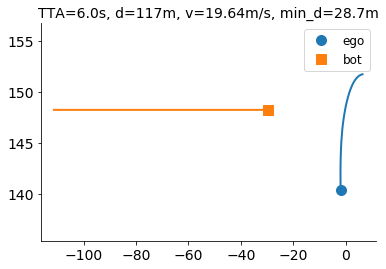

In [21]:
anim = animate_traj(traj)
HTML(anim.to_html5_video())
# HTML(anim.to_jshtml())

Let's take a look at the time course of the trials to see if the times of bot spawn (start of decision) and response (termination of a decision) are determined correctly

In [22]:
def plot_traj(traj, fig_path='figures'):    
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response)
    idx_min_distance = int(traj.iloc[0].idx_min_distance)
    tta = int(traj.iloc[0].tta_condition)
    d = int(traj.iloc[0].d_condition)
    
    fig, axes = plt.subplots(4, 1, figsize=(12,9), sharex=True)
    axes[0].plot(traj.t, traj.ego_v, color='C0')
    axes[0].plot(traj.t[idx_bot_spawn], traj.ego_v[idx_bot_spawn], color='C7', ls='', marker='o')
    axes[0].plot(traj.t[idx_response], traj.ego_v[idx_response], color='C7', ls='', marker='x')
    axes[0].set_ylabel('ego v')

    axes[1].plot(traj.t, traj.throttle, color='C1')
    axes[1].plot(traj.t[idx_bot_spawn], traj.throttle[idx_bot_spawn], color='C7', ls='', marker='o')
    axes[1].plot(traj.t[idx_response], traj.throttle[idx_response], color='C7', ls='', marker='x')
    axes[1].set_ylabel('ego throttle')

    axes[2].plot(traj.t[:], traj.d_ego_bot[:], color='C2')
    axes[2].plot(traj.t[idx_bot_spawn], traj.d_ego_bot[idx_bot_spawn], color='C7', ls='', marker='o')
    axes[2].plot(traj.t[idx_response], traj.d_ego_bot[idx_response], color='C7', ls='', marker='x')
    axes[2].set_ylabel('d(ego to bot)')

    axes[3].plot(traj.t[:], traj.tta[:], color='C3')
    axes[3].plot(traj.t[idx_bot_spawn], traj.tta[idx_bot_spawn], color='C7', ls='', marker='o', 
                 label='Oncoming car appears')
    axes[3].plot(traj.t[idx_response], traj.tta[idx_response], color='C7', ls='', marker='x', 
                 label='Decision is made')
    axes[3].set_ylabel('tta')
    axes[3].set_ylim((0, 7))

    axes[3].set_xlabel('time $t$')

    legend = fig.legend(loc='upper left', bbox_to_anchor=(1.0, 0.9), 
                        title=str(traj.iloc[0].name) + '\nTTA=%.1fs, d=%im' % (tta, d))
    legend.get_title().set_fontsize('18')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_path, '%s.png' % (str(traj.iloc[0].name))))

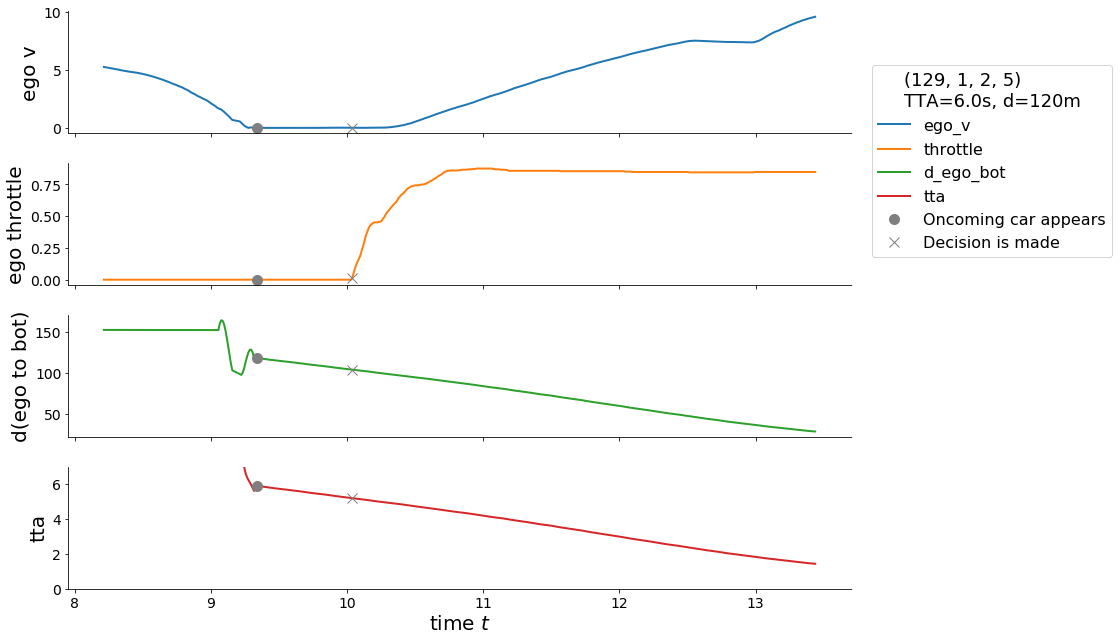

In [23]:
plot_traj(traj)

To check whether the algorithms of detecting 1) determining whether a driver decided to turn or to wait, 2) the momement the decision started (bot spawned), and 3) the moment decision was made, we save animations and time series plots for all trials

In [19]:
for name, traj in data[data.min_distance<5].groupby(data.index.names):
    anim = animate_traj(traj)
    anim.save('figures/wait/%s.mp4' % (str(traj.iloc[0].name)), dpi=300)
    plot_traj(traj, 'figures/wait')
    plt.close()

In [20]:
for name, traj in data[data.min_distance>5].groupby(data.index.names):
    anim = animate_traj(traj)
    anim.save('figures/turn/%s.mp4' % (str(traj.iloc[0].name)), dpi=300)
    plot_traj(traj, 'figures/turn')
    plt.close()

Visual inspection of all trials confirmed that the chosen algorithms accurately detect turn/wait decisions and response times. The only exception are response times in the trials where a subject started moving away but then changed their mind and decided to wait in the end. These RTs are short, although the decision is "wait"

In [24]:
measures[(measures.RT<1) & (measures['decision']=='Wait')]

idx_bot_spawn  idx_response  \
subj_id session route intersection_no                                
129     1       1     5                        114.0         161.0   
                      8                         45.0          87.0   
                      14                         0.0          68.0   
                      22                        55.0         122.0   
                2     2                         70.0         137.0   
                      3                         39.0         120.0   
                      13                        40.0         123.0   
                      14                        17.0          98.0   
                      25                        76.0         148.0   
                4     20                        70.0         140.0   
        2       6     21                        57.0         144.0   
                7     16                        55.0         133.0   
                8     7                         77.0         155.0   
                      22                        62.0         137.0   
389     1       2     6                         25.0          97.0   
                      16                        63.0          95.0   
                      17                       142.0         211.0   
                3     4                         83.0         176.0   
                      6                         27.0         116.0   
                      19                        62.0         142.0   
                4     1                         54.0         115.0   
                      10                        60.0         123.0   
                      12                        62.0         105.0   
                      13                        73.0         122.0   
                      17                        78.0         140.0   
        2       5     10                        83.0         133.0   
                      25                        87.0         141.0   
                8     2                         75.0          82.0   
                      12                        90.0         154.0   
                      14                        90.0         149.0   
...                                              ...           ...   
618     2       6     1                         53.0         112.0   
                      22                        30.0          63.0   
                7     4                         54.0         116.0   
642     1       1     1                         16.0          96.0   
                4     13                        40.0         130.0   
                      24                        19.0          26.0   
        2       5     7                         87.0         178.0   
                      11                        86.0         134.0   
                      15                        13.0          83.0   
                      25                        62.0         122.0   
                6     1                         60.0         138.0   
                      8                         76.0         141.0   
755     1       1     1                         27.0          35.0   
                      8                         54.0         114.0   
                      11                        18.0          39.0   
                      19                        13.0          59.0   
                      21                         0.0          92.0   
                      24                        47.0          96.0   
                2     3                         44.0          96.0   
                3     19                        49.0          95.0   
                      20                        25.0          75.0   
                      24                        58.0          98.0   
        2       5     1                         15.0          87.0   
                      10                        61.0         131.0   
                      17                        3

For instance, this one

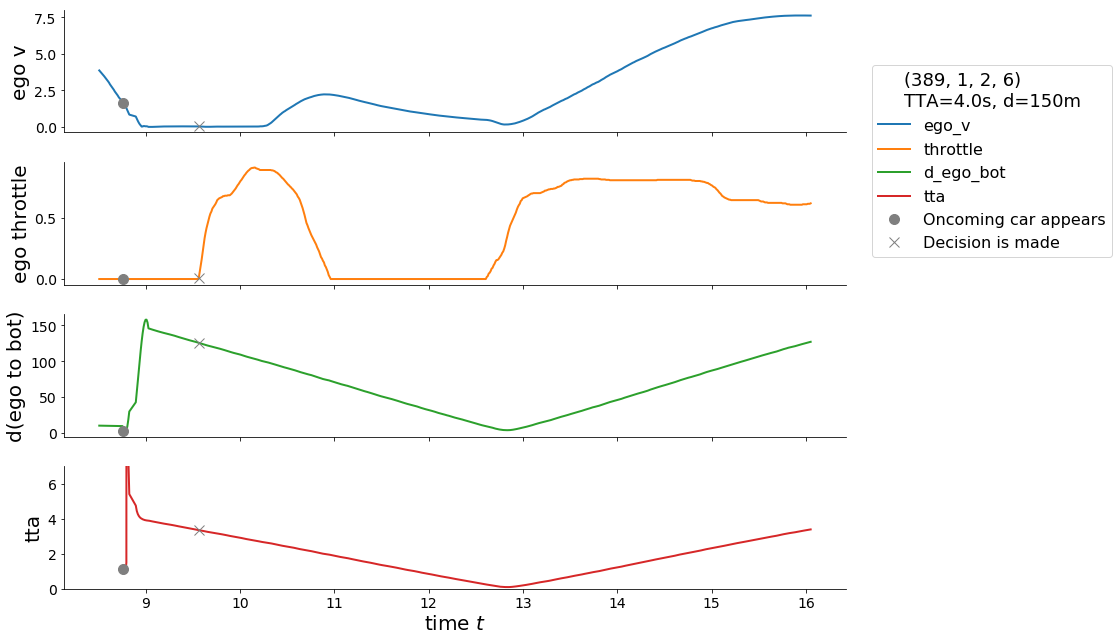

In [25]:
plot_traj(data.loc[random.choice(measures[(measures.RT<1) & (measures['decision']=='Wait')].index)])

In future, we will update the RT detection algorithm so that it ignores small movements of the car due to short presses of the gas pedal. These changes-of-mind will also be interesting to model, possibly using the extension of the DDM model by Resulaj et al (2009)

In [26]:
measures = measures.reset_index()
measures_turn = measures_turn.reset_index()

# Effect of TTA on decision and RT

With the exception of one subject (642), probability of turning increases with time gap

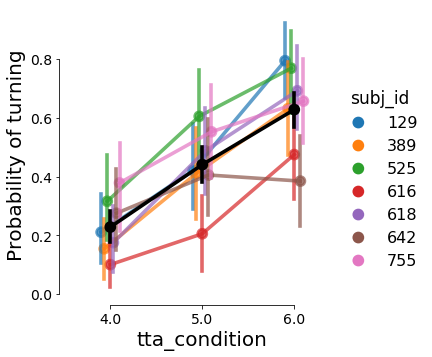

In [70]:
def plot_dv_vs_iv_by_subj(measures, dv, iv):
    g = sns.catplot(kind='point', data=measures, x=iv, y=dv, hue='subj_id', join=True, dodge=0.2)
    ax = g.axes[0][0]
    sns.despine(trim=True, offset=5)
    plt.setp(ax.collections, alpha=.7)
    plt.setp(ax.lines, alpha=.7)    
    plt.setp(ax.collections, zorder=1)
    plt.setp(ax.lines, zorder=1)
    sns.pointplot(ax=ax, data=measures, x=iv, y=dv, marker='o', color='k', zorder=10)    
    plt.setp(ax.collections[-1], zorder=10)
    return ax
    
ax = plot_dv_vs_iv_by_subj(measures, dv='is_turn_decision', iv='tta_condition')
ax.set_ylabel('Probability of turning');

Now let's see if there are any abnormalities in the RTs. We could already see in some trials that in "wait" decisions RT is very short because of "changes-of-mind", but also people would often start pressing the gas pedal before the oncoming car passes, so RT is often less than TTA even in "wait" decisions. So far we focus on the "turn" decisions, so we can ignore "wait" RTs altogether. Still, it's intersting to see RTs for all trials (but bear in mind that some "wait" trials will have weird RTs)

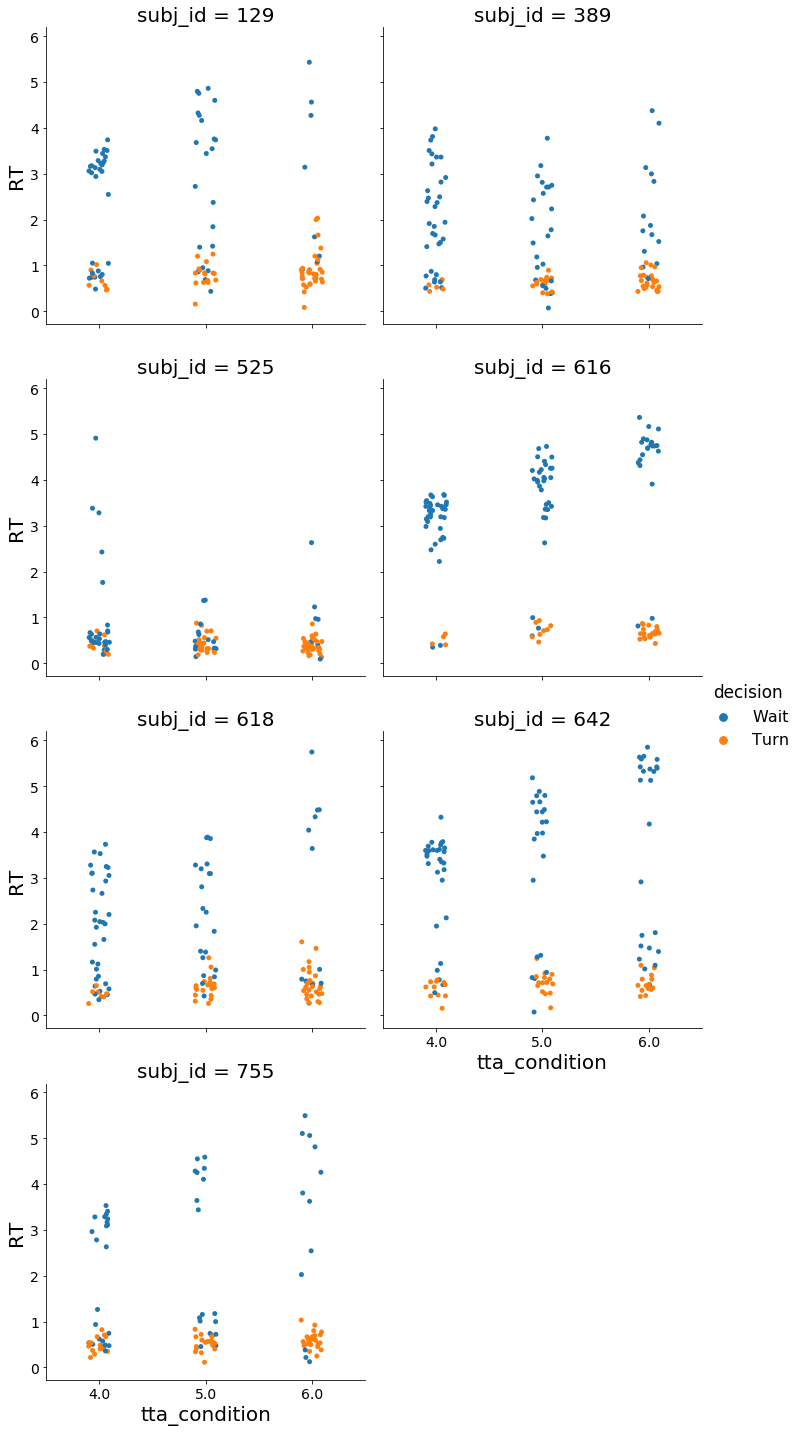

In [49]:
grid = sns.catplot(data=measures, x='tta_condition', y='RT', col='subj_id', col_wrap=2, hue='decision')

Zooming in on the 'turn' decisions, we look at RTs as a function of TTA condition

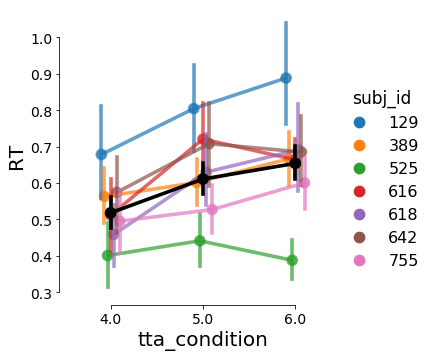

In [71]:
plot_dv_vs_iv_by_subj(measures_turn, iv='tta_condition', dv='RT')

Interestingly, we have a positive relationship between RT and TTA condition, which isn't what would be predicted by the constant-drift-rate DDM. The latter implies that for low-probability decisions we have longest response times, while we see the opposite picture. Is that because the drift rate in our case decreases with time? Or because TTA is not the primary perceptual variable used by the drivers? Or because it takes us longer to recognize low speed values (larger TTA)?

# Effect of distance on decision and RT

As expected, probability of turning also increases with distance

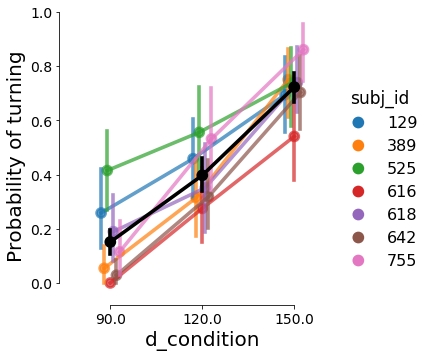

In [73]:
ax = plot_dv_vs_iv_by_subj(measures, iv='d_condition', dv='is_turn_decision')
ax.set_ylabel('Probability of turning');

Interestingly though, RT doesn't seem to change with distance in general (although there are subjects for which decisions at 90m take more time) 

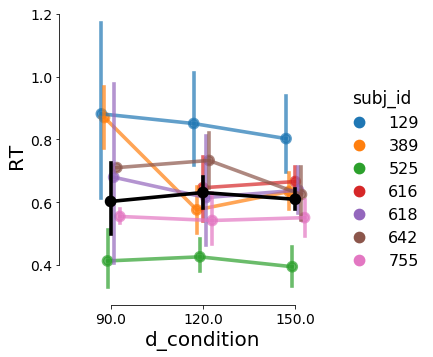

In [76]:
plot_dv_vs_iv_by_subj(measures_turn, iv='d_condition', dv='RT');

# Aggregate data for all subjects

Let's aggregate the data for all subjects, given that the patterns seem to be fairly consistent across the sample so far.

This is just to illustrate that probability of turning increases with both distance and TTA.

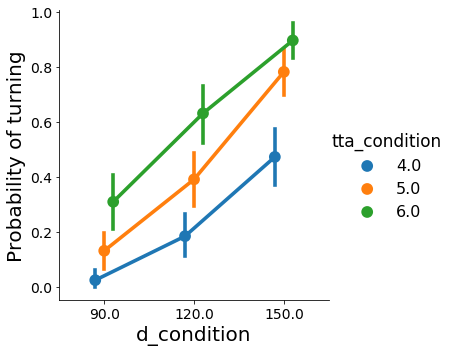

In [83]:
g = sns.catplot(kind='point', data=measures, x='d_condition', y='is_turn_decision', hue='tta_condition', join=True, dodge=0.2)
g.axes[0][0].set_ylabel('Probability of turning');

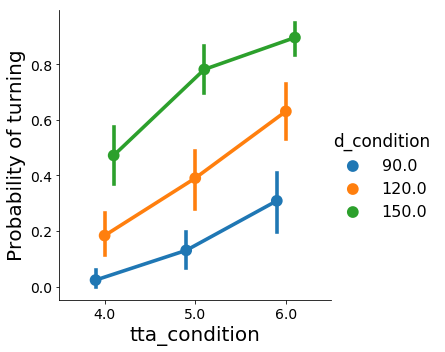

In [84]:
g = sns.catplot(kind='point', data=measures, x='tta_condition', y='is_turn_decision', hue='d_condition', join=True, dodge=0.2)
g.axes[0][0].set_ylabel('Probability of turning');

It's interesting how difference between 90 and 120 meters is less than difference between 120 and 150 across all TTAs.  At the same time, difference between TTA=4 and TTA=5 is small at 90 meters, but is very large at 150 meters; this is reversed for difference between TTA=5 and TTA=6.

Aggregated data shows also that RT increases with TTA, except for d=90 (but note more uncertainty because of very few "turn" decisions made in this condition, especially at TTA=4)

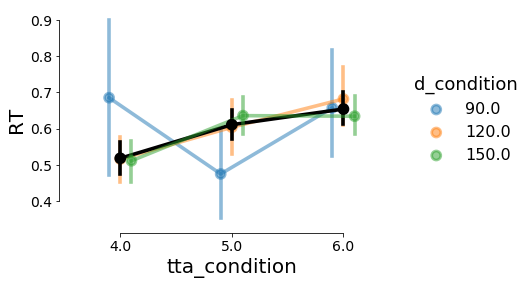

In [118]:
def plot_RT_vs_var(measures, var, hue, violin=False):
    if violin:
        g = sns.catplot(data=measures, x=var, y='RT', kind='violin', color='grey', inner=None)
        ax = g.axes[0][0]
    else:
        fig, ax = plt.subplots()
    sns.pointplot(ax=ax, data=measures, x=var, y='RT', hue=hue, dodge=0.2)
    plt.setp(ax.lines, alpha=.5)
    plt.setp(ax.collections, alpha=.5)
    sns.pointplot(ax=ax, data=measures, x=var, y='RT', color='k')
    plt.setp(ax.collections[-1], zorder=10)
    sns.despine(trim=True, offset=5)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    ax.get_legend().set_title(hue, prop={'size':18})
    return ax

plot_RT_vs_var(measures_turn, var='tta_condition', hue='d_condition');

At the same time, RT does not change with distance

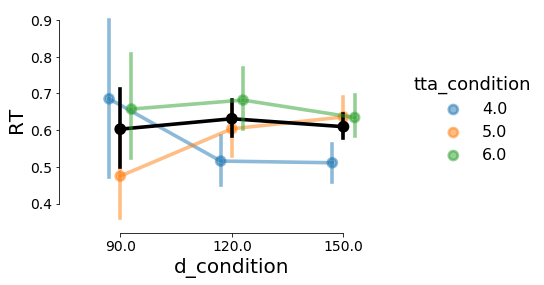

In [119]:
plot_RT_vs_var(measures_turn, var='d_condition', hue='tta_condition');

# Response time distributions

Let's look into the RT distributions to see if there are the long tails there (we'd expect to see them for instance in the 'vanilla' DDM)

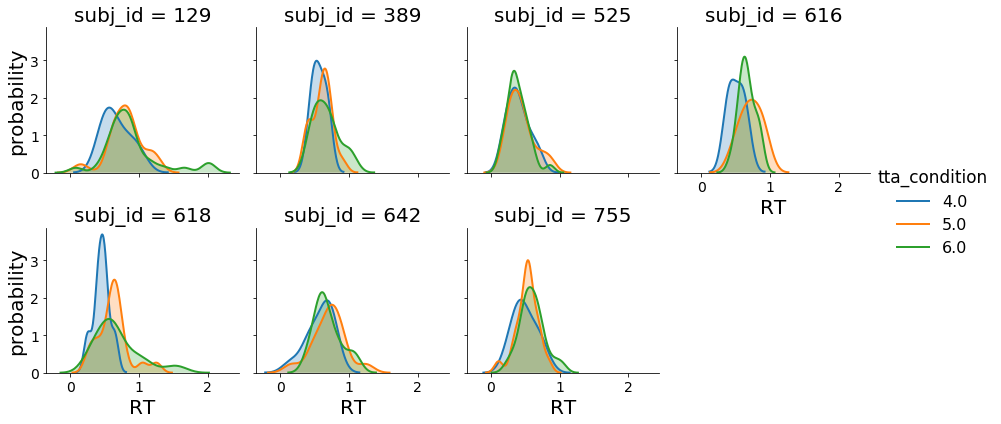

In [125]:
g = sns.FacetGrid(measures_turn, col='subj_id', hue='tta_condition', col_wrap=4)
g.map(sns.kdeplot, 'RT', shade=True).add_legend().set_axis_labels('RT', 'probability')

In [152]:
def plot_RT_kde(measures_turn, var, logscale=False):
    for value, group in measures_turn.groupby(var):
        ax = sns.kdeplot(group.RT, label=value, shade=True)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    ax.get_legend().set_title(var, prop={'size':18})
    ax.set_xlabel('RT')
    ax.set_ylabel('probability')
    if logscale:
        ax.set_ylim((0.0001, 10))
        ax.set_yscale('log')
    return ax

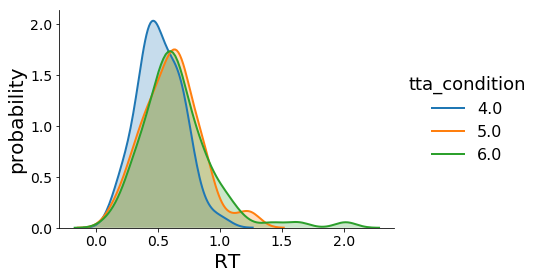

In [154]:
plot_RT_kde(measures_turn, var='tta_condition', logscale=False)

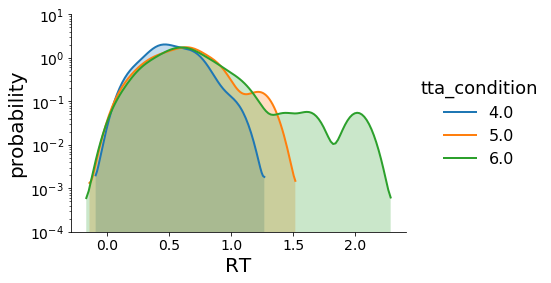

In [155]:
plot_RT_kde(measures_turn, var='tta_condition', logscale=True)

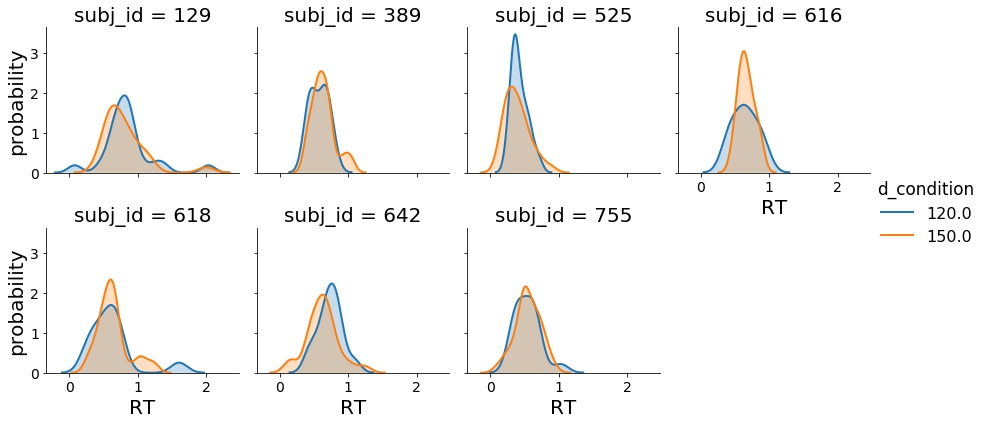

In [140]:
g = sns.FacetGrid(measures_turn[measures_turn.d_condition>90], col='subj_id', hue='d_condition', col_wrap=4)
g.map(sns.kdeplot, 'RT', shade=True).add_legend().set_axis_labels('RT', 'probability')

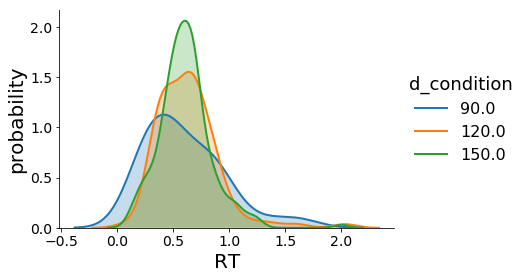

In [149]:
ax = plot_RT_kde(measures_turn, var='d_condition')

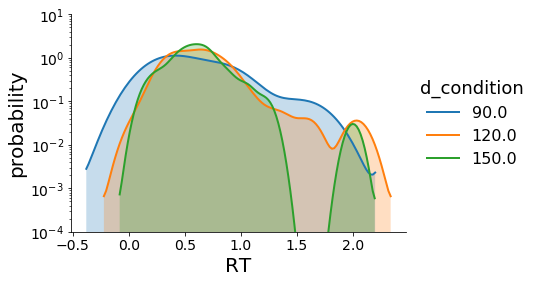

In [156]:
ax = plot_RT_kde(measures_turn, var='d_condition', logscale=True)